In [1]:
import os
from galileo.handlers.langchain import GalileoCallback
from galileo import GalileoDecorator

os.environ["GALILEO_PROJECT"] = "demo-simple-agent-langgraph"
os.environ["GALILEO_LOG_STREAM"]="dev"

os.environ["LANGCHAIN_PROJECT"]="galileo-demo-simple-agent-langgraph"

# Create a callback with the custom logger
galileo_v2_callback = GalileoCallback(
    start_new_trace=True,   # Whether to start a new trace for each chain
    flush_on_chain_end=True # Whether to flush traces when chains end
) 
galileo_context = GalileoDecorator()

from braintrust import init_logger
from braintrust_langchain import BraintrustCallbackHandler

init_logger(project="galileo-simple-agent-langgraph", api_key=os.environ.get("BRAINTRUST_API_KEY"))
braintrust_callback = BraintrustCallbackHandler()

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

from langgraph.prebuilt import ToolNode, tools_condition

memory = MemorySaver()


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [3]:
from dotenv import load_dotenv

load_dotenv("../.env")

True

In [4]:
from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch

llm = init_chat_model("openai:gpt-4.1-mini", callbacks=[galileo_v2_callback, braintrust_callback])

@tool
def human_assistance(query: str) -> str:
    """Request assistance from a human."""
    human_response = interrupt({"query": query})
    return human_response["data"]

tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    # Disable parallel tool calling to avoid repeating tool invocations when we resume
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}

graph_builder.add_node("chatbot", chatbot)


In [5]:
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile(checkpointer=memory)

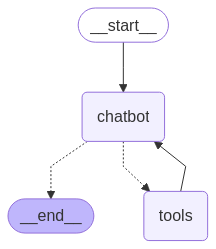

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    print("Something went wrong while trying to display the graph.")
    pass

In [ ]:
config = {"configurable": {"thread_id": "1"}}

def stream_with_interrupt_handling():
    while True:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        
        # Start streaming the response
        events = graph.stream(
            {"messages": [{"role": "user", "content": user_input}]},
            config,
            stream_mode="values",
        )
        
        # Process events until we hit an interrupt or complete
        for event in events:
            if "messages" in event:
                event["messages"][-1].pretty_print()
        
        # After streaming completes, check if we hit an interrupt
        snapshot = graph.get_state(config)
        
        # Check if the graph is at an interrupt
        if snapshot.next:
            assert snapshot.next[0] == "tools", f"Unexpected value for snapshot.next: {snapshot.next}"
            # We're at an interrupt - get human input
            print("\n[System: Agent is requesting human assistance]")
            
            # Extract the query from the interrupt state
            interrupt_msg = None
            for msg in reversed(snapshot.values["messages"]):
                if hasattr(msg, "tool_calls") and msg.tool_calls:
                    for tool_call in msg.tool_calls:
                        if tool_call["name"] == "human_assistance":
                            interrupt_msg = tool_call["args"]["query"]
                            break
                    if interrupt_msg:
                        break
            
            if interrupt_msg:
                print(f"[Agent query: {interrupt_msg}]")
            
            # Get human response
            human_response = input("Human: ")
            
            # Resume with the human response
            human_command = Command(resume={"data": human_response})
            
            # Continue streaming from where we left off
            events = graph.stream(human_command, config, stream_mode="values")
            for event in events:
                if "messages" in event:
                    event["messages"][-1].pretty_print()


In [9]:
# snapshot = graph.get_state(config)
# print(snapshot)

stream_with_interrupt_handling()

================================ Human Message =================================

What is the latest news about india and pakistan?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_EFe35CWLT0O7NfydGnUMnv3m)
 Call ID: call_EFe35CWLT0O7NfydGnUMnv3m
  Args:
    query: latest news about India and Pakistan
    topic: news
    search_depth: basic
================================= Tool Message =================================
Name: tavily_search

{"query": "latest news about India and Pakistan", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://www.skynews.com.au/australia-news/todays-news-headlines-india-and-pakistan-agree-to-ceasefire/video/00cc30eab693e6306172ef8cc8673261?nk=168895e0761b3b6e4217baa16429b7e4-1746936271", "title": "Today’s News Headlines: India and Pakistan agree to ceasefire - Sky News Australia", "score": 0.79369855, "published_date": "Sun, 11 May 2025 00:01:50 GMT", "c